# EDA of the tweets of realDonaldTrump

So the summary that I have currently is that 

* you really need to use as much recent data as possible, even the last year of data is turrible.
* Need to adjust for hours
* Need to adjust for days of the week

In [78]:
import json
from pathlib import Path
import sys
from collections import Counter
import datetime

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#!{sys.executable} -m pip install matplotlib

## Read them in and turn into DataFrame

okay there is the json, but there is the more accurate csv

In [3]:
tweet_path = Path("../data/realDonaldTrump.json")
tweet_path.exists()

True

In [4]:
tweet_dict = dict()

with open(tweet_path, 'r') as read_file:
    for thing in read_file:
        tweet_json = json.loads(thing)
        
        # combine time and date
        date_time = tweet_json["date"] + " " + tweet_json["time"]
        time_zone = tweet_json['timezone']
        
        tweet_dict[date_time] = tweet_json["id"]

In [5]:
date_time

'2017-01-01 06:00:10'

In [6]:
json.loads(thing)

{'id': 815422340540547073,
 'conversation_id': '815422340540547073',
 'created_at': 1483246810000,
 'date': '2017-01-01',
 'time': '06:00:10',
 'timezone': 'CEST',
 'user_id': 25073877,
 'username': 'realdonaldtrump',
 'name': 'Donald J. Trump',
 'place': '',
 'tweet': 'TO ALL AMERICANS-\n#HappyNewYear & many blessings to you all! Looking forward to a wonderful & prosperous 2017 as we work together to #MAGA🇺🇸 pic.twitter.com/UaBFaoDYHe',
 'mentions': [],
 'urls': [],
 'photos': ['https://pbs.twimg.com/media/C1D2SsLVEAIn1UJ.jpg'],
 'replies_count': 19020,
 'retweets_count': 27943,
 'likes_count': 112710,
 'hashtags': ['#happynewyear', '#maga'],
 'cashtags': [],
 'link': 'https://twitter.com/realDonaldTrump/status/815422340540547073',
 'retweet': False,
 'quote_url': '',
 'video': 0,
 'near': '',
 'geo': '',
 'source': '',
 'user_rt_id': '',
 'user_rt': '',
 'retweet_id': '',
 'reply_to': [{'user_id': '25073877', 'username': 'realDonaldTrump'}],
 'retweet_date': '',
 'translate': '',
 't

In [7]:
df = pd.DataFrame.from_dict(tweet_dict, orient='index', columns=['ID'])

In [8]:
df.index = pd.to_datetime(df.index)

## CSV

In [9]:
tweet_path = Path("../data/realDonaldTrump.csv")
tweet_path.exists()

True

In [10]:
df = pd.read_csv(tweet_path)


In [11]:
df.index = pd.to_datetime(df['created_at'])

In [12]:
df = pd.DataFrame(df['id_str'])

In [13]:
df.columns = ['ID']

In [14]:
df.head()

,ID
created_at,
2020-04-28 20:24:20,1255231394923646976
2020-04-28 20:14:31,1255228926428942339
2020-04-28 20:13:47,1255228739027456001
2020-04-28 14:43:53,1255145720136359945
2020-04-28 14:04:50,1255135893557403648


## Quantitative description

### Per day, just in general

In [15]:
by_day = df.groupby(df.index.date).count()
by_day["ID"].mean()

14.564529558701082

In [16]:
by_day["ID"].std()

13.730539227066087

In [17]:
daily_count = pd.DataFrame.from_dict(Counter(by_day["ID"]), orient='index', columns=['count']).sort_index()

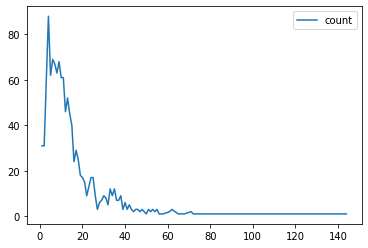

In [18]:
daily_count.plot()

In [19]:
daily_count['probability'] = daily_count['count'] / daily_count['count'].sum()

In [20]:
daily_count.head()

,count,probability
1,31,0.025812
2,31,0.025812
3,60,0.049958
4,88,0.073272
5,62,0.051624


### By Day of Week

Monday = 0

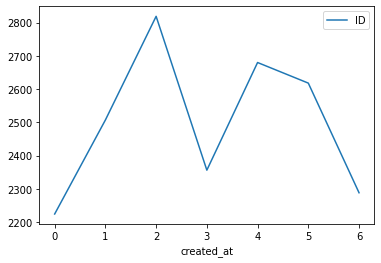

In [21]:
day_of_week = df.groupby(df.index.dayofweek).count()

day_of_week.plot()

## By Hour

Honestly, he probably does sleep for 4 hours a night

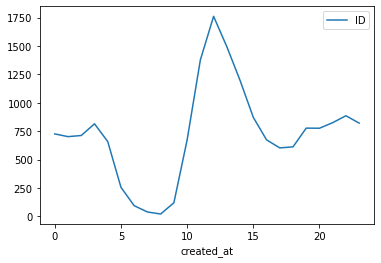

In [22]:
by_hour = df.groupby(df.index.hour).count()
by_hour.plot()

## A priori weekly odds

tl;dr we just see what the odds are of each of the buckets at the start of each week

In [23]:
by_day["sum_7"] = by_day.rolling(window=7).sum()

In [36]:
prior_counts = {
  "149" : sum(by_day["sum_7"] <= 149),
  "150-159" : sum((by_day["sum_7"] >= 150) & (by_day["sum_7"] < 160)),
  "160-169" : sum((by_day["sum_7"] >= 160) & (by_day["sum_7"] < 170)),
  "170-179" : sum((by_day["sum_7"] >= 170) & (by_day["sum_7"] < 180)),
  "180-189" : sum((by_day["sum_7"] >= 180) & (by_day["sum_7"] < 190)),
  "190-199" : sum((by_day["sum_7"] >= 190) & (by_day["sum_7"] < 200)),
  "200-209" : sum((by_day["sum_7"] >= 200) & (by_day["sum_7"] < 210)),
  "210-219" : sum((by_day["sum_7"] >= 210) & (by_day["sum_7"] < 219)),
  "220" : sum(by_day["sum_7"] >= 220)
}


In [37]:
prior_counts

{'149': 929,
 '150-159': 29,
 '160-169': 19,
 '170-179': 23,
 '180-189': 32,
 '190-199': 18,
 '200-209': 29,
 '210-219': 16,
 '220': 98}

## That <149 number is awfully suss

Let's investigate

In [55]:
#df.groupby(df.index.hour).count()
weekly_lt_149 = by_day[by_day["sum_7"] <= 149]
weekly_lt_149.index = pd.to_datetime(weekly_lt_149.index)

weekly_lt_149.groupby(weekly_lt_149.index.year).count()

,ID,sum_7
2017,357,357
2018,355,355
2019,205,205
2020,12,12


In [65]:
bday = by_day.drop(['sum_7'], axis=1)

In [76]:
# GB=DF.groupby([(DF.index.year),(DF.index.month)]).sum()
bday.index = pd.to_datetime(bday.index)
bmonth = bday.groupby([(bday.index.year), (bday.index.month)]).sum()
bmonth

ID
2017 1    214
     2    154
     3    147
     4    152
     5    155
     6    212
     7    242
     8    267
     9    306
     10   290
     11   261
     12   199
2018 1    205
     2    175
     3    171
     4    257
     5    259
     6    309
     7    336
     8    380
     9    383
     10   384
     11   338
     12   294
2019 1    369
     2    249
     3    405
     4    431
     5    692
     6    487
     7    692
     8    690
     9    797
     10  1018
     11   862
     12  1126
2020 1    964
     2    898
     3    971
     4    751

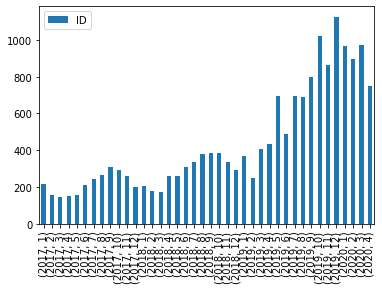

In [75]:
bmonth.plot.bar()

### Using the last year of data

Yeah clearly we're drawingc from a different distribution since May-July of last year, so let's just use the last year of data as our prior

In [91]:
df_s = df[:df.iloc[0].name - datetime.timedelta(days=365)]

In [93]:
by_day = df_s.groupby(df_s.index.date).count()
by_day["ID"].mean()

27.215846994535518

In [94]:
by_day["ID"].std()

17.73595899114083

In [95]:
daily_count = pd.DataFrame.from_dict(Counter(by_day["ID"]), orient='index', columns=['count']).sort_index()

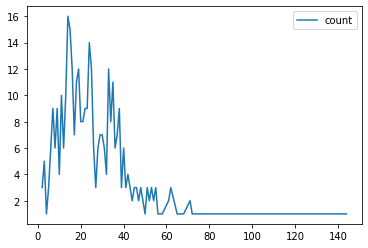

In [96]:
daily_count.plot()

In [97]:
daily_count['probability'] = daily_count['count'] / daily_count['count'].sum()

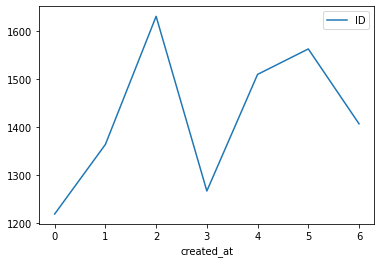

In [99]:
day_of_week = df_s.groupby(df_s.index.dayofweek).count()

day_of_week.plot()

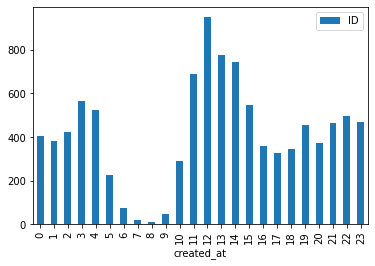

In [110]:
by_hour = df_s.groupby(df_s.index.hour).count()
by_hour.plot.bar()

In [101]:
by_day["sum_7"] = by_day.rolling(window=7).sum()

In [102]:
prior_counts = {
  "149" : sum(by_day["sum_7"] <= 149),
  "150-159" : sum((by_day["sum_7"] >= 150) & (by_day["sum_7"] < 160)),
  "160-169" : sum((by_day["sum_7"] >= 160) & (by_day["sum_7"] < 170)),
  "170-179" : sum((by_day["sum_7"] >= 170) & (by_day["sum_7"] < 180)),
  "180-189" : sum((by_day["sum_7"] >= 180) & (by_day["sum_7"] < 190)),
  "190-199" : sum((by_day["sum_7"] >= 190) & (by_day["sum_7"] < 200)),
  "200-209" : sum((by_day["sum_7"] >= 200) & (by_day["sum_7"] < 210)),
  "210-219" : sum((by_day["sum_7"] >= 210) & (by_day["sum_7"] < 219)),
  "220" : sum(by_day["sum_7"] >= 220)
}


In [107]:
weeklies = pd.DataFrame.from_dict(prior_counts, orient='index', columns=["Counts"])

In [109]:
weeklies["Counts"] / weeklies["Counts"].sum()

149        0.268156
150-159    0.078212
160-169    0.050279
170-179    0.067039
180-189    0.086592
190-199    0.050279
200-209    0.081006
210-219    0.044693
220        0.273743
Name: Counts, dtype: float64